# Exploring a Data Repository

<br>Owner: **Johann Cohen-Tanugi** ([@johannct](https://github.com/johannct)) based on work by **Rob Morgan** ([@rmorgan10](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@rmorgan10)), **Phil Marshall** ([@drphilmarshall](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@drphilmarshall)), **Alex Drlica-Wagner** ([@kadrlica](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@kadrlica))
<br>Last Verified to Run: **2020-11-26**
<br>Verified Stack Release: **w2020_47**

This notebook examines the content of a data repository and shows how to determine the inputs for each component.  

### Learning Objectives:
After working through and studying this notebook you should be able to understand how to use the Butler to figure out: 
   1. What a data repo is;
   2. Which data types are present in a data repository;
   3. If coadds have been made, what the available tracts are;
   4. Which parts of the sky those tracts cover.
   
### Logistics
This notebook is intended to be runnable from CC or NERSC jupyterlab or local sessions from a local git clone of https://github.com/LSSTDESC/StackClub.


## Set Up

In [2]:
import os
import sys
import warnings
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import numpy as np
import os, glob
%matplotlib inline


In [3]:
dc2_version='2.2i_dr6_wfd'
try:
    #if you are on a jupyterLab session at CC, it is necessary to force the env variable to 'in2p3'
    os.environ["DESC_GCR_SITE"]='in2p3'
    import desc_dc2_dm_data
    butler=desc_dc2_dm_data.get_butler(dc2_version)
    repo=desc_dc2_dm_data.REPOS[dc2_version]
except ImportError:
    %pip install git+https://github.com/LSSTDESC/desc-dc2-dm-data
    import desc_dc2_dm_data
    butler=desc_dc2_dm_data.get_butler(dc2_version)
    repo=desc_dc2_dm_data.REPOS[dc2_version]
except ValueError:
#at NERSC
#repo = ''/global/cfs/cdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1''
#at CC
    repo = '/sps/lssttest/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1/'
    butler = Butler(repo)

/pbs/home/t/tanugi/.local/lib/python3.7/site-packages/desc-dc2-dm-data/desc_dc2_dm_data/site.py:28: UserWarning: Site determined from env variable DESC_GCR_SITE = in2p3, which differs from node name 483db08967fa
  _DESC_SITE_ENV, site_from_env, site_from_socket


## What is a Data repo?

A data repo is a directory containing raw images, calibration files, metadata and configuration information, defining an LSST-format dataset. Data repositories contain either a `_mapper` file or a `repositoryCfg.yaml` file, which record the "obs package" that was used to organize the data. The obs package gives the repository more structure and organization than an ordinary data directory. Let's take a look at this file structure in the HSC data repo.

### The DC2 Top Data Repo: What's in there?

In [20]:
topdir = os.path.join(repo,'../..')

We'll use the `dc2` data repository as our testing ground. As a production directory, it contains a lot of files presiding to the actual production pipelines, and not of interest here. The important files and directories are the following :
 - **raw** directory : it contains all the raw files ingested by the butler and registered into the **registry.sqlite3** database.
 - **CALIB** and **calibrations** : these hold calibration products that the Rubin science pipelines use to process the raw images.
 - **ref_cats** : a directory containing the reference catalogue(s) for astrometry and photometry calibrations.
 - **rerun** : the directory, built by the butler, that will contain all the processing outputs of the science pipelines : calibrated exposures, coadded images and catalogues, etc...
 - **_mapper** : a file that indicates to the butler what instrument is supposed to be considered for the processing task
 Let's have a further look at the latter

In [21]:
import subprocess as sub
out=sub.check_output (['cat', os.path.join(topdir,'_mapper')])
print(out.decode())

lsst.obs.lsst.imsim.ImsimMapper



We can see the `_mapper` file here, and at contains one line giving the name of the `Mapper` object for the HSC repo:

In [14]:
# Import the Mapper object once you know its name
from lsst.obs.lsst.imsim import ImsimMapper

You can get some more information on this object like this:

In [17]:
#help(ImsimMapper)

The mapper defines a (large) number of different "dataset types". Some of these are specific to this particular data repo, others are more general. Even filtering out some intermediate dataset types, we are still left with a long list. But, once we figure out which dataset types we are interested in, we can start querying for information about those datasets.

In [22]:
mapper = ImsimMapper(root=repo)
all_dataset_types = mapper.getDatasetTypes()

remove = ['_config', '_filename', '_md', '_sub', '_len', '_schema', '_metadata']

shortlist = []
for dataset_type in all_dataset_types:
    keep = True
    for word in remove:
        if word in dataset_type:
            keep = False
    if keep:
        shortlist.append(dataset_type)

#print(shortlist)

### Great, but where is the actual data

We found where the raw images are, in the topdir, but the actual processing outputs are actually two level down, inside the **rerun** directory. Under **rerun** several directories correspond to dedicated parts of latest versions of the processing of the 2.2i simulations. The one we will focus on here is provided by the varaible `repo` defined above

In [31]:
out=sub.check_output (['ls', repo])
print(out.decode())

config
deepCoadd
deepCoadd-results
repositoryCfg.yaml
schema
tracts_mapping.sqlite3



The **repositoryCfg.yaml** file allows the mapper to recognize that this is a data repository, and its content points the butler to additional data repositories, joined to this one. 

In [32]:
out=sub.check_output(['cat', os.path.join(repo,'repositoryCfg.yaml')])
print(out.decode())

!RepositoryCfg_v1
_mapper: &id001 !!python/name:lsst.obs.lsst.imsim.ImsimMapper ''
_mapperArgs: {}
_parents:
- ../run2.2i-calexp-v1
- ../run2.2i-coadd-wfd-dr6-v1-u
- ../run2.2i-coadd-wfd-dr6-v1-grizy
- !RepositoryCfg_v1
  _mapper: *id001
  _mapperArgs: {}
  _parents: []
  _policy: null
  _root: ../..
  dirty: true
_policy: null
_root: null
dirty: true



One can recognize a relative path to the top directory (`_root`), the mapper content, and three parent data repositories that were chained to the one we are looking at: `run2.2i-calexp-v1` contains the outputs of the exposure calibrations (single visit processing), `run2.2i-coadd-wfd-dr6-v1-*` which contain the outputs of the coaddition processing, while the current repository contains the final outputs, measurements and forced photometry on the coadds, and metacalibration of the shear, under the `deepCoadd` and `deepCoadd-results` directory.

## Obtaining Basic Dataset Properties Using the Butler
The butler has been instantiated above, and knows about the data repository structure  and chaining, as described previously.

Now we can start using Butler methods to query metadata for the repo. For this dataset, we can look at the filters used, number of visits, number of pointings, etc. by examining the Butler's keys and metadata. For these basic properties, we will look at the `calexp` and `src` tables. The contents of these tables are derived from the processing of individual sensors, and exist in the parent folder. (That means that we can use either of our two butlers to query for them.)

Note that the metadata is created from the raw exposures loaded into the sqlite registry. The fact that we can get metadata for a specific datasetType and dataId **does not** imply that the data exist on disk (we will check this in a subsequent step).

In [36]:
# This would be faster if only one query were issued...
visits = butler.queryMetadata('calexp', ['visit'])
ccds = butler.queryMetadata('calexp', ['detector'])
filters = butler.queryMetadata('calexp', ['filter'])
sources = butler.queryMetadata('src', ['id'])

# It is possible to specify multiple formats -- i.e., butler.queryMetadata('calexp', ['visit','ccd'])
metadata = butler.queryMetadata('calexp', ['visit','detector','filter'])

In [38]:
num_visits = len(visits)
num_ccds = len(ccds)
num_filters = len(filters)
num_sources = len(sources)
num_metadata = len(metadata)

In [39]:
print("The DC2 {} repo contains {} visits.".format(dc2_version,num_visits))
print("The DC2 {} repo contains {} ccds.".format(dc2_version,num_ccds))
print("The DC2 {} repo contains {} filters.".format(dc2_version,num_filters))
print("The DC2 {} repo contains {} sources.".format(dc2_version,num_sources))
# print("The HSC {}/{} rerun contains {} coadd sources.".format(rerun_id,depth,num_coadd_sources))
# print("The HSC {}/{} rerun contains {} forced sources.".format(rerun_id,depth,num_forced_sources))

The DC2 2.2i_dr6_wfd repo contains 31488 visits.
The DC2 2.2i_dr6_wfd repo contains 189 ccds.
The DC2 2.2i_dr6_wfd repo contains 6 filters.
The DC2 2.2i_dr6_wfd repo contains 3652662 sources.


Of course we find out that the butler sees 189 ccd possible entries (there are 189 science detectors in the camera) and 6 filters.... But here are also the grand total of visits and sources (detected on calibrated exposures, not coadded images)

### So where are the Calexps and Source Catalogs?

Notice that while we were able to get metadata for the `processCcd` outputs (the `calexp` and `src`), that **does not** guarantee that these products are on disk. The metadata is created from the raw inputs stored in the registry and a template for the derived data products. In this case, we have a reason to be suspicious: remember that when we examined the directory structure we did not see a directory for the `processCcd` products. 

To check the existence of the data requires the use of the `datasetExists` method of the `butler`. Let's give this a try.

First we select the metadata for a specific calexp

In [44]:
dataId={'filter':'i','visit':665637,'detector':10}
butler.queryMetadata('calexp', ['visit','detector','filter'], dataId=dataId)

[(665637, 10, 'i')]

Ok, so we have the metadata, let's try to get the calexp...

In [46]:
try: 
    butler.get('calexp',dataId=dataId)
except Exception as e:
    print(str(e))
    print("\nWhat? Does the data exist?")

# Explicitly check for existence
exists = butler.datasetExists('calexp',dataId=dataId)
print("\nbutler.datasetExists: " + str(exists))


butler.datasetExists: True


The dataset exists, and we can decide to inspect the image, or the source catalogue associated with this visit. All this is for another tutorial!

## Coadd Sky Area

One may also be interested in the total sky area imaged in a given processing (and thus a given repository). First let's remind ourselves that for the purpose of processing, the sky is tiled by overlapping tracts. Each tract is also divided into overlapping patches. Coaddition occurs at the patch level, while the WCS solution is constructed over the tract. The geometrical sizes of tracts and patches are configurables when defining how the processing of data from a given instrument should proceed. For DC2, there are for instance 49 patches per tract. 

Let's use the repository's structure to list the available tracts :

In [47]:
# Collect tract indices from file names
tracts = sorted([int(os.path.basename(x)) for x in
                 glob.glob(os.path.join(repo, 'deepCoadd-results', 'merged', '*'))])
num_tracts = len(tracts)

print("Found {} merged tracts in repo {}".format(num_tracts, repo))

Found 173 merged tracts in repo /sps/lssttest/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1


A quick way of estimating the sky area covered is to sum the areas of the inner boxes of all the tracts. For more information on the properties of tracts, you can look at the [Documentation](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1skymap_1_1tract_info_1_1_tract_info.html).

As a quick note, the file structure only tells us the names of the tracts in the particular rerun to look at. The actual `TractInfo` objects are obtained by selecting the tracts we want from the `deepCoadd_skyMap` dataset in our particular rerun repo. Therefore, we will have to ask the butler to serve this dataset for the particular rerun. 

In [49]:
# Calculate area from all tracts
skyMap = butler.get('deepCoadd_skyMap')
total_area = 0.0  #deg^2
plotting_vertices = []
for test_tract in tracts:
    # Get inner vertices for tract
    tractInfo = skyMap[test_tract]
    vertices = tractInfo._vertexCoordList
    plotting_vertices.append(vertices)
    
    #calculate area of box
    av_dec = 0.5 * (vertices[2][1] + vertices[0][1])
    av_dec = av_dec.asRadians()
    delta_ra_raw = vertices[0][0] - vertices[1][0] 
    delta_ra = delta_ra_raw.asDegrees() * np.cos(av_dec)
    delta_dec= vertices[2][1] - vertices[0][1]
    area = delta_ra * delta_dec.asDegrees()
    
    #combine areas
    total_area += area
    

# Round off the total area for presentation purposes
rounded_total_area = round(total_area, 2)

print("Total area imaged (sq deg): ",rounded_total_area)

Total area imaged (sq deg):  422.82


The result differs from the expected 300 sq deg for several reasons : the computation here is a flat approximation, the tracts are actually overlapping, and the DC2 processing extends beyond the strict 300 sq deg region to avoid edge effects within the fiducial region.

## Plotting the sky coverage

For this we will need our list of merged `tracts` from above, and also the `skyMap` object. We can then extract the sky coordinates of the corners of each tract, and use them to draw a set of rectangles to illustrate the sky coverage, following Jim Chiang's LSST DESC tutorial [dm_butler_skymap.ipynb](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/dm_butler_skymap.ipynb).

In the future, we could imagine overlaying the focal plane and color the individual visits, using more of the code from Jim's notebook. Let's wait to see what functionality the Gen3 Butler provides first, and maybe return to visualization later.

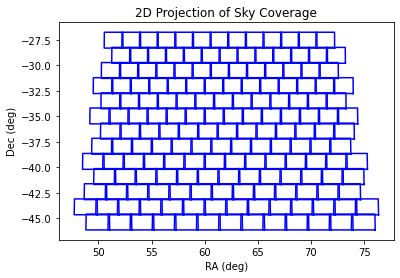

In [50]:
plt.figure()

for tract in tracts:
    tractInfo = skyMap[tract]
        
    corners = [(x[0].asDegrees(), x[1].asDegrees()) for x in tractInfo.getVertexList()]
    x = [k[0] for k in corners] + [corners[0][0]]
    y = [k[1] for k in corners] + [corners[0][1]]
    
       
    plt.plot(x,y, color='b')
    
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('2D Projection of Sky Coverage')

plt.show()

We could imagine plotting the patches as well, to show which tracts were incomplete - but this gives us a rough idea of where our data is on the sky. More in-depth usage of the skymap can be found in other tutorials.

## Finding a Coadd Object Catalog

Since we know we have `deepCoadd` images, we might want to find the sources detected in those images. These are the precursors of `Objects`. If forced photometry has been run on these sources, there should be `deepCoadd_forced_src` catalogs present. The `config` tells us which tasks have been run in the rerun, but metadata describing the results of the run is not propagated back into the registry database in the parent folder. So, we need to get data from the `under_butler`.

Since the registry only knows about the raw exposures (and products that can be directly derived from templates using the raws), we can't get valid metadata from `queryMetadata` directly. Instead, we query the directory structure for a valid filter, tract, patch combination.

In [53]:
dirname=os.path.join(repo,'deepCoadd-results')
print('filters: '+dirname)
!ls $dirname
filter='i'

dirname = os.path.join(dirname, filter)
print('\ntracts: '+dirname)
!ls $dirname
tract=3828

dirname = os.path.join(dirname,str(tract))
print('\npatches: '+dirname)
!ls $dirname
patch='1,3'

dirname = os.path.join(dirname,patch)
print('\ndata products: '+dirname)
!ls $dirname

filters: /sps/lssttest/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1/deepCoadd-results
g  i  merged  r  u  y  z

tracts: /sps/lssttest/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1/deepCoadd-results/i
2723  2897  3075  3258	3444  3634  3829  4027	4229  4434  4642  4855	5070
2724  2898  3076  3259	3445  3635  3830  4028	4230  4435  4643  4856	5071
2725  2899  3077  3260	3446  3636  3831  4029	4231  4436  4644  4857	5072
2726  2900  3078  3261	3447  3637  3832  4030	4232  4437  4645  4858	5073
2727  2901  3079  3262	3448  3638  3833  4031	4233  4438  4646  4859	5074
2728  2902  3080  3263	3449  3639  3834  4032	4234  4439  4647  4860
2729  2903  3081  3264	3450  3640  3835  4033	4235  4440  4648  5062
2730  2904  3082  3265	3451  3641  3836  4034	4236  4441  4848  5063
2731  2905  3083  3266	3452  3642  3837  4035	4428  4636  4849  5064
2732  2906  3084  3267	3453  3643  4022  4224	4429  4637  4850  5065
2733  2907  3085  3268	3454  382

We can also get some available tract, patches from the `skyMap` object. We need to feed it a list of coordinates defining a polygon to search for viable tract,patch info.

In [83]:
from lsst.geom import SpherePoint, Angle
# Create a list of corners of the polygon to search.
coordList = [SpherePoint(Angle(np.radians(60)),Angle(np.radians(-32))),
             SpherePoint(Angle(np.radians(60)),Angle(np.radians(-33))),
             SpherePoint(Angle(np.radians(61)),Angle(np.radians(-33))),
             SpherePoint(Angle(np.radians(61)),Angle(np.radians(-32)))
            ]
# Print the tract,patch info
tractInfo = skyMap.findTractPatchList(coordList)
for _tract in tractInfo:
    print(_tract[0])
    for _patch in _tract[1]:
        print('  ',_patch)

TractInfo(id=4433)
   PatchInfo(index=(0, 0))
   PatchInfo(index=(0, 1))
   PatchInfo(index=(0, 2))
   PatchInfo(index=(0, 3))
TractInfo(id=4434)
   PatchInfo(index=(2, 0))
   PatchInfo(index=(2, 1))
   PatchInfo(index=(2, 2))
   PatchInfo(index=(2, 3))
   PatchInfo(index=(3, 0))
   PatchInfo(index=(3, 1))
   PatchInfo(index=(3, 2))
   PatchInfo(index=(3, 3))
   PatchInfo(index=(4, 0))
   PatchInfo(index=(4, 1))
   PatchInfo(index=(4, 2))
   PatchInfo(index=(4, 3))
   PatchInfo(index=(5, 0))
   PatchInfo(index=(5, 1))
   PatchInfo(index=(5, 2))
   PatchInfo(index=(5, 3))
   PatchInfo(index=(6, 0))
   PatchInfo(index=(6, 1))
   PatchInfo(index=(6, 2))
   PatchInfo(index=(6, 3))
TractInfo(id=4229)
   PatchInfo(index=(0, 5))
   PatchInfo(index=(0, 6))
   PatchInfo(index=(1, 5))
   PatchInfo(index=(1, 6))
   PatchInfo(index=(2, 5))
   PatchInfo(index=(2, 6))
   PatchInfo(index=(3, 5))
   PatchInfo(index=(3, 6))
TractInfo(id=4230)
   PatchInfo(index=(6, 5))
   PatchInfo(index=(6, 6))


In [85]:
# Here we grab the coadd source catalog for a specific filter
dataId={'filter':'i','tract':tract,'patch':patch}
coadd_sources = butler.get('deepCoadd_forced_src',dataId=dataId)
coadd_sources.asAstropy()

id,coord_ra,coord_dec,parent,deblend_nChild,base_SdssCentroid_x,base_SdssCentroid_y,base_SdssCentroid_xErr,base_SdssCentroid_yErr,base_SdssCentroid_flag,base_SdssCentroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_TransformedCentroid_x,slot_Centroid_x,base_TransformedCentroid_y,slot_Centroid_y,base_TransformedCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_InputCount_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_PsfFlux_flag_badCentroid,base_SdssCentroid_flag_badInitialCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,ext_convolved_ConvolvedFlux_0_flag_badCentroid,ext_convolved_ConvolvedFlux_1_flag_badCentroid,ext_convolved_ConvolvedFlux_2_flag_badCentroid,ext_convolved_ConvolvedFlux_3_flag_badCentroid,ext_convolved_ConvolvedFlux_flag_badCentroid,ext_photometryKron_KronFlux_flag_badInitialCentroid,modelfit_DoubleShapeletPsfApprox_flag_badCentroid,slot_Centroid_flag,undeblended_base_CircularApertureFlux_flag_badCentroid,undeblended_base_PsfFlux_flag_badCentroid,undeblended_ext_convolved_ConvolvedFlux_0_flag_badCentroid,undeblended_ext_convolved_ConvolvedFlux_1_flag_badCentroid,undeblended_ext_convolved_ConvolvedFlux_2_flag_badCentroid,undeblended_ext_convolved_ConvolvedFlux_3_flag_badCentroid,undeblended_ext_convolved_ConvolvedFlux_flag_badCentroid,undeblended_ext_photometryKron_KronFlux_flag_badInitialCentroid,base_InputCount_flag,base_InputCount_value,base_InputCount_flag_noInputs,base_SdssShape_xx,base_SdssShape_yy,base_SdssShape_xy,base_SdssShape_xxErr,base_SdssShape_yyErr,base_SdssShape_xyErr,base_SdssShape_x,base_SdssShape_y,base_SdssShape_instFlux,base_SdssShape_instFluxErr,base_SdssShape_psf_xx,slot_PsfShape_xx,base_SdssShape_psf_yy,slot_PsfShape_yy,base_SdssShape_psf_xy,slot_PsfShape_xy,base_SdssShape_instFlux_xx_Cov,base_SdssShape_instFlux_yy_Cov,base_SdssShape_instFlux_xy_Cov,base_SdssShape_flag,base_SdssShape_flag_unweightedBad,base_SdssShape_flag_unweighted,base_SdssShape_flag_shift,base_SdssShape_flag_maxIter,base_SdssShape_flag_psf,base_TransformedShape_xx,slot_Shape_xx,base_TransformedShape_yy,slot_Shape_yy,base_TransformedShape_xy,slot_Shape_xy,base_TransformedShape_flag,base_GaussianFlux_flag_badShape,slot_Shape_flag,modelfit_DoubleShapeletPsfApprox_0_xx,modelfit_DoubleShapeletPsfApprox_0_yy,modelfit_DoubleShapeletPsfApprox_0_xy,modelfit_DoubleShapeletPsfApprox_0_x,modelfit_DoubleShapeletPsfApprox_0_y,modelfit_DoubleShapeletPsfApprox_0_0,modelfit_DoubleShapeletPsfApprox_0_1,modelfit_DoubleShapeletPsfApprox_0_2,modelfit_DoubleShapeletPsfApprox_0_3,modelfit_DoubleShapeletPsfApprox_0_4,modelfit_DoubleShapeletPsfApprox_0_5,modelfit_DoubleShapeletPsfApprox_1_xx,modelfit_DoubleShapeletPsfApprox_1_yy,modelfit_DoubleShapeletPsfApprox_1_xy,modelfit_DoubleShapeletPsfApprox_1_x,modelfit_DoubleShapeletPsfApprox_1_y,modelfit_DoubleShapeletPsfApprox_1_0,modelfit_DoubleShapeletPsfApprox_1_1,modelfit_DoubleShapeletPsfApprox_1_2,modelfit_DoubleShapeletPsfApprox_flag,modelfit_DoubleShapeletPsfApprox_flag_invalidPointForPsf,modelfit_DoubleShapeletPsfApprox_flag_invalidMoments,modelfit_DoubleShapeletPsfApprox_flag_maxIterations,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,base_CircularApertureFlux_3_0_flag,base_CircularApertureFlux_3_0_flag_apertureTruncated,base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_4_5_instFlux,base_CircularApertureFlux_4_5_instFluxErr,base_CircularApertureFlux_4_5_flag,base_CircularApertureFlux_4_5_flag_apertureTruncated,base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,base_CircularApertureFlux_6_0_instFlux,base_CircularApertureFlux_6_0_instFluxErr,base_CircularApertureFlux_6_0_flag,base_CircularApertureFlux_6_0_flag_apertureTruncated,base_CircularApertureFlux_6_0_flag_sincCoeffsTruncat

In [87]:
# We can also get the merged detections
dataId={'tract':4434,'patch':'3,3'}
merged_sources = butler.get('deepCoadd_mergeDet',dataId=dataId)

In [95]:
#One can get the available keys by running : 
#coadd_sources.getSchema()

## Visualizing Simple Measurements

We'd like to know something about the sources that have been detected and measured, beyond a simple total number. We create a simple histogram of the Kron flux of sources in our HSC-I band tile. You can find more details on merging catalogs across bands, etc on the [Science Pipelines documentation](https://pipelines.lsst.io/getting-started/multiband-analysis.html).

Text(0.5, 1.0, 'i 3828 1,3')

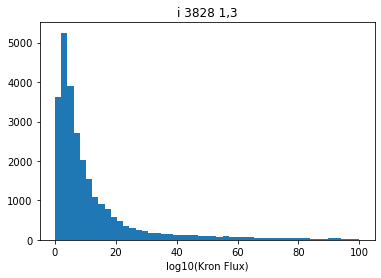

In [97]:
plt.figure()
plt.hist(coadd_sources['ext_photometryKron_KronFlux_instFlux'],bins=np.linspace(0,100,50))
plt.xlabel("log10(Kron Flux)")
plt.title("{filter} {tract} {patch}".format(filter=filter,tract=tract,patch=patch))